## Clamp_ vs. ReLU
This method compares using clamp_ in training vs. using a ReLU activation function to enforce non-negative estimates. Do the two approaches perform comparably?

In [15]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F


from AAUtoSig_init import AAUtoSig, train_AAUtoSig
from functions import simulate_counts, plotsigs, cosine_HA, split_data

# Clamp_ model
Firstly we implement the NMFAE model, which is a one-hidden layer linear autoencoder. Here the non-negativity constraint is enforced by a clamp_ argument in the training method.

# ReLU model
Secondly we implement the same NMFAE model, but now the non-negativity constraint is enforced by introducing a ReLU activation function after encoding.

# Evaluate
Now we evaluate the results on simulated data.

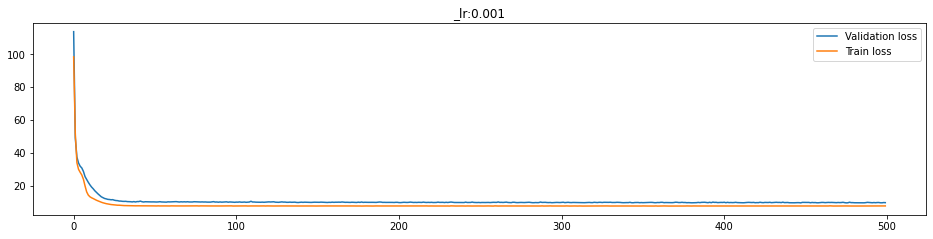

<Figure size 432x288 with 0 Axes>

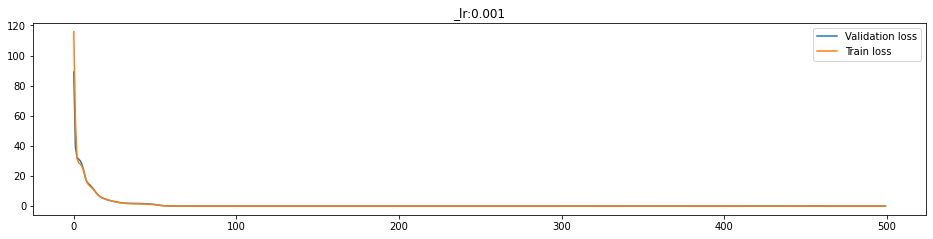

<Figure size 432x288 with 0 Axes>

In [16]:
n_sigs = 5

m_clamp = AAUtoSig(96, 5, non_negativity = None)
m_relu = AAUtoSig(96, 5, non_negativity = "ReLU")

V,S,E = simulate_counts(5, 2000)
train_data, validation_data = split_data(V.T, 0.8)
trinucleotide = V.index
mutation = [t[2:5] for t in trinucleotide]


# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer_clamp = torch.optim.Adam(m_clamp.parameters(),
                            lr = 1e-3)
optimizer_relu = torch.optim.Adam(m_relu.parameters(),
                            lr = 1e-3)

np.random.seed(20)                             
train_AAUtoSig(epochs = 500, 
                model = m_clamp, 
                x_train = train_data,
                x_test = validation_data, 
                criterion = loss_function, 
                optimizer = optimizer_clamp,
                batch_size = 16,
                non_negative = "all")


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_clamp = m_clamp.dec1.weight.data    
sigs_clamp = pd.DataFrame(sigs_clamp.numpy()) 

# Using an Adam Optimizer with lr = 1e-3
np.random.seed(20)                                                         
train_AAUtoSig(epochs = 500, 
                model = m_relu, 
                x_train = train_data,
                x_test = validation_data, 
                criterion = loss_function, 
                optimizer = optimizer_relu,
                batch_size = 16,
                non_negative = None)


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_relu = F.relu(m_relu.dec1.weight.data)    
sigs_relu = pd.DataFrame(sigs_relu.numpy()) 


In [17]:
cosine_clamp, perm_clamp = cosine_HA(sigs_clamp.T, S.T)
cosine_relu, perm_relu = cosine_HA(sigs_relu.T, S.T)
print("cosine values for clamped:")
print(cosine_clamp.diagonal())
print(np.mean(cosine_clamp.diagonal()))

print("cosine values for relu:")
print(cosine_relu.diagonal())
print(np.mean(cosine_relu.diagonal()))

cosine = cosine_HA(sigs_relu.T, sigs_clamp.T)[0].diagonal()

print("cosine values between methods:")
print(cosine)
print(np.mean(cosine))

cosine values for clamped:
[0.4558513  0.37441056 0.99366347 0.97573034 0.9404279 ]
0.748016713580612
cosine values for relu:
[0.76167711 0.71866392 0.88254831 0.7899405  0.40534473]
0.7116349153124357
cosine values between methods:
[0.8860046  0.85216122 0.28097244 0.26552316 0.59001304]
0.5749348917535502


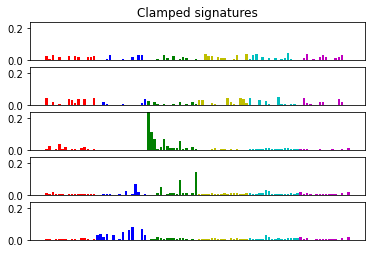

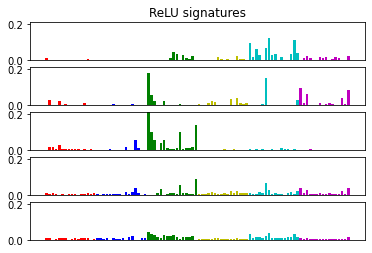

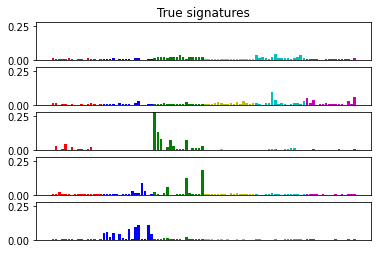

In [18]:
plotsigs(trinucleotide, sigs_clamp[perm_clamp].to_numpy(), 5, "Clamped signatures")  
plotsigs(trinucleotide, sigs_relu[perm_relu].to_numpy(), 5, "ReLU signatures")  
plotsigs(trinucleotide, S.to_numpy(), 5, "True signatures")  